In [222]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_selection import f_classif # anova 
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
from sklearn import preprocessing  



In [223]:
hotels = pd.read_csv('data\hotels.csv')
display(hotels.head())
display(hotels.info())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

## 1. Работа со строковыми данными

Поочередно рассмотрим строковые признаки, оценим возможность формриования нового признака для формирования модели

In [224]:
# Адреc отеля содержит сведения о стране, где расположен отель. с помощью функции split
# сформируем списки и возьмем последний элемент для формирования признака country. Новый
# признак пока тоже текстовый,  


hotels['hotel_address'] = hotels['hotel_address'].apply(lambda x: x.split(' '))
hotels['hotel_address'].head(10)
hotels['country'] = hotels['hotel_address'].apply(lambda x: x[-1])
hotels['country'].value_counts()


Kingdom        196774
Spain           45132
France          44830
Netherlands     43006
Austria         29178
Italy           27883
Name: country, dtype: int64

In [225]:
bin_encoder = ce.BinaryEncoder(cols=['country']) # указываем столбец для кодирования
country_bin = bin_encoder.fit_transform(hotels['country'])
hotels = pd.concat([hotels, country_bin], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [226]:
# в датасете 1492 уникальных отеля, количество упоминаний одного отеля не превышает 1%.
# Кодирование данного признака приведет к формированию большого окличества новых признаков,
# что сделает модель сложной. Данный признак на данном этапе подлежит исключению
hotels['hotel_name'].value_counts()
hotels.drop(columns=['hotel_name', 'country', 'hotel_address'], axis=1, inplace=True)

In [227]:
# Уменьшим количество значений признака страны рецензента - объединим страны, упоминающиеся менее 2000 раз, в категорию другие 

nation_counts = hotels['reviewer_nationality'].value_counts()
nation_list = nation_counts[nation_counts <= 2000].index.tolist()
  
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: 'Other' if x in nation_list else x)


In [228]:
bin_encoder_2 = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
country_bin = bin_encoder_2.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, country_bin], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   review_date                                 386803 non-null  object 
 2   average_score                               386803 non-null  float64
 3   reviewer_nationality                        386803 non-null  object 
 4   negative_review                             386803 non-null  object 
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

In [229]:
# Наличие/отсутствие негативного отзыва
hotels[hotels['negative_review'] == 'No Negative'].shape[0]
hotels['is_negative'] = hotels['negative_review'].apply(lambda x: 0 if x == 'No Negative' else 1)

In [230]:
# Наличи/отсутствие положительного отзыва
hotels[hotels['positive_review'] == 'No Positive'].shape[0]
hotels['is_positive'] = hotels['positive_review'].apply(lambda x: 0 if x == 'No Positive' else 1)

In [231]:
hotels.drop(columns=['reviewer_nationality', 'negative_review', 'positive_review'], axis=1, inplace=True)

In [232]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   review_date                                 386803 non-null  object 
 2   average_score                               386803 non-null  float64
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   review_total_positive_word_counts           386803 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   reviewer_score                              386803 non-null  float64
 8   tags                                        386803 non-null  object 
 9   days_since_review                           386803 non-null  object 
 

In [233]:
# Работа с датами. Можно по годам выделить
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['year'] = hotels['review_date'].apply(lambda x: x.year)

In [234]:
bin_encoder_3 = ce.BinaryEncoder(cols=['year']) # указываем столбец для кодирования
country_bin = bin_encoder_3.fit_transform(hotels['year'])
hotels = pd.concat([hotels, country_bin], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386803 non-null  int64         
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   review_total_negative_word_counts           386803 non-null  int64         
 4   total_number_of_reviews                     386803 non-null  int64         
 5   review_total_positive_word_counts           386803 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64         
 7   reviewer_score                              386803 non-null  float64       
 8   tags                                        386803 non-null  object       

In [55]:
def seasons(in_date):
    """make nunmber of season (1 - spring, 2 - summer, 3 - autumn, 4 - winter)

    Args:
        in_date (int64): number of month

    Returns:
        number of season, _type_: int64
    """
    if in_date in [3, 4, 5]:
        return 'spring'
    elif in_date in [6, 7, 8]:
        return 'summer'
    elif in_date in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'
    hotels['season'] = hotels['month'].apply(seasons)

In [235]:
# работа с признаком tags. Соберем все тэги в словарь, где ключ - уникльный тэг,  значение - количество упоминания тэга
def tags_count(argum):
    """function for counting

    Args:
        argum (_type_): _description_
    """
    list = argum.strip("'[]").split(',')
    for i in range(len(list)):
        list[i] = list[i].strip("' ")
    #dict = {}
    #for element in list:
    #    if element not in dict.keys():
    #        dict[element] = 1
    #    else:
    #        dict[element] += 1
    return list


    

In [236]:
dict_tags = hotels['tags'].apply(tags_count)

In [237]:
dict_tags

0         [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Solo traveler, Modern Double Ro...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
386798    [Leisure trip, Group, Club Double or Twin Room...
386799    [Leisure trip, Couple, Standard Double Room, S...
386800    [Business trip, Solo traveler, Single Room, St...
386801    [Leisure trip, Solo traveler, Deluxe Double Ro...
386802    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 386803, dtype: object

In [238]:
dict_count = {}

for di in dict_tags:
    for elem in di:
        if elem not in dict_count.keys():
            dict_count[elem] = 1
        else:
            dict_count[elem] += 1

dict_count

{'Leisure trip': 313593,
 'Couple': 189212,
 'Studio Suite': 543,
 'Stayed 2 nights': 100263,
 'Submitted from a mobile device': 230778,
 'Business trip': 61989,
 'Standard Double Room': 24151,
 'Stayed 1 night': 145373,
 'Solo traveler': 81235,
 'Modern Double Room Echo': 4,
 'Stayed 3 nights': 72000,
 'Standard Room with 1 Double Bed': 677,
 'Standard Double or Twin Room': 13062,
 'Stayed 6 nights': 7399,
 'Superior Twin Room': 4540,
 'Double Room Non Smoking': 977,
 'Superior Double Room': 23550,
 'Stayed 4 nights': 35748,
 'Double Room': 26386,
 'Twin Hilton Guest Room': 711,
 'Family with young children': 45836,
 'Luxury Room': 233,
 'Double or Twin Room Non Smoking': 394,
 'Double or Twin Room': 16824,
 'Standard Room': 3171,
 'Group': 49088,
 'Comfort Double or Twin Room': 1832,
 'Standard': 934,
 'Executive Double Room': 4763,
 'Twin Room Non Smoking': 509,
 'Studio Double Family': 395,
 'Double Twin Superior Room': 21,
 'X Ordinary Room': 66,
 '2 rooms': 9287,
 'King Deluxe Gu

In [239]:
hotels['Leisure trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['Couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
hotels['Solo traveler'] = hotels['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
hotels['mobile submitted'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [240]:
def nights_col(ser):
    l = []
    for i in ser:
        if 'Stayed' in i:
            l.append(i)
    return str(''.join(l).strip('[]').split()).strip('[]').split()
                
    
            

In [241]:
def nights_cocol(ser):
    l = []
    for i in ser:
        if 'Stayed' or 'night' in i:
            ser.remove(i)
    return ser

In [242]:
nights = dict_tags.apply(nights_col)

In [243]:
nights = nights.apply(nights_cocol)

In [244]:
nights = nights.apply(lambda x: ''.join(x).strip("'[]',"))


In [260]:
nights = nights.apply(lambda x: np.nan if x == '' else x)
nights = nights.fillna(nights.mode())

In [261]:
nights.value_counts()

1     145373
2     100263
3      72000
4      35748
5      15611
6       7399
7       5549
8       1910
9        966
10       663
11       306
12       217
14       184
13       174
15        87
16        38
17        27
18        24
19        23
21        19
20        17
30        10
27        10
22         8
28         7
23         6
26         6
24         5
25         4
29         3
Name: tags, dtype: int64

In [262]:
hotels['nights_col'] = nights

In [248]:

hotels.drop(columns=['review_date', 'tags'], axis=1, inplace=True)

In [249]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  object 
 8   lat                                         384355 non-null  float64
 9   lng                                         384355 non-null  float64
 

In [271]:
fill_hotels = hotels.fillna({'lat': hotels['lat'].mean(), 'lng': hotels['lng'].mean()})

In [251]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int64')

In [263]:
hotels['nights_col'] = hotels['nights_col'].apply(lambda x: hotels['nights_col'].mode() if x is np.nan else x)

In [270]:
hotels['nights_col'] = hotels['nights_col'].astype('int64')

In [256]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         384355 non-null  float64
 9   lng                                         384355 non-null  float64
 

C:\Users\ak88r\AppData\Local\Temp\ipykernel_2728\964170551.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fill_hotels.corr(), annot=True)


<Axes: >

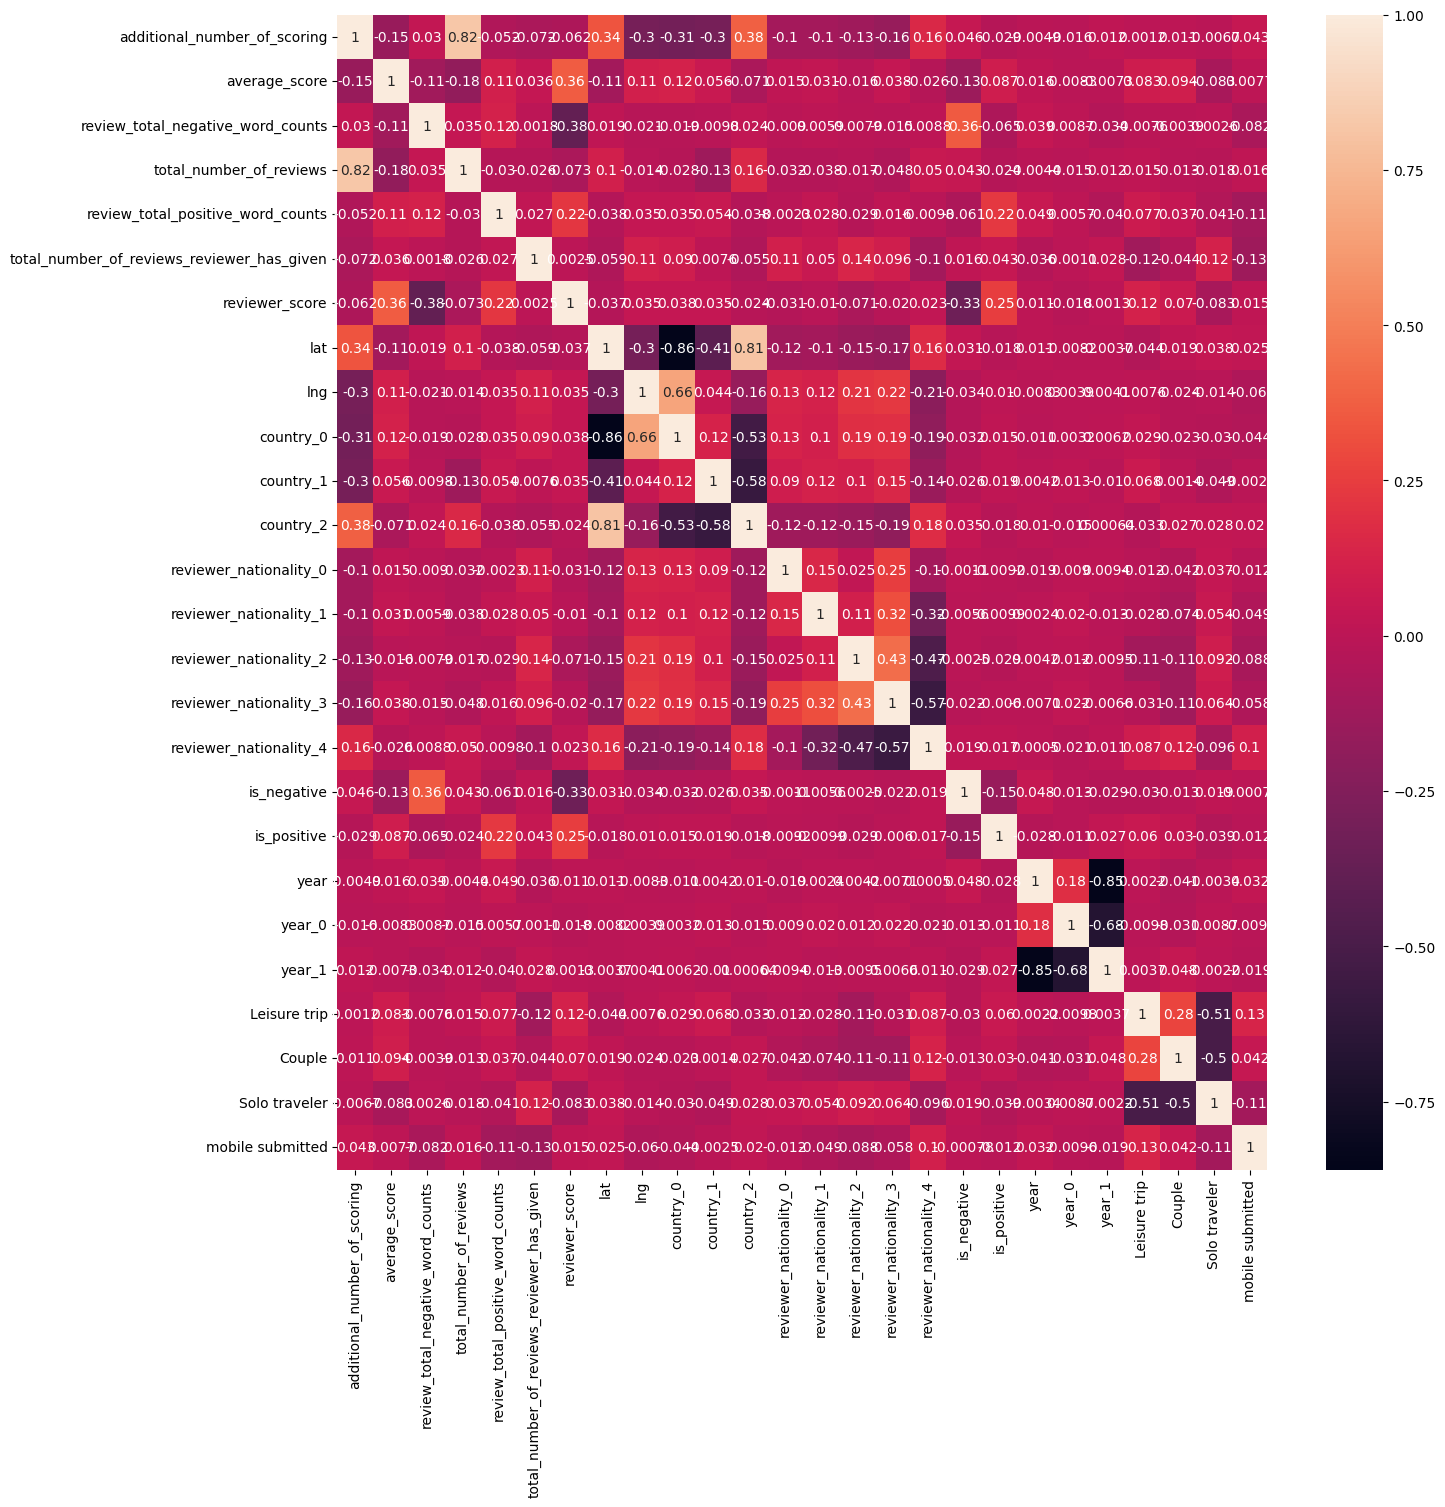

In [265]:
fig, ax = plt.subplots(figsize=(15, 15))
#ax1.set_title('Матрица корреляции')

sns.heatmap(fill_hotels.corr(), annot=True)

In [272]:
fill_hotels.drop(columns=['additional_number_of_scoring', 'lat', 'lng', 'days_since_review'], axis=1, inplace=True)

### Оценка значимости показателей

In [273]:
fill_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   total_number_of_reviews                     386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   reviewer_score                              386803 non-null  float64
 6   country_0                                   386803 non-null  int64  
 7   country_1                                   386803 non-null  int64  
 8   country_2                                   386803 non-null  int64  
 9   reviewer_nationality_0                      386803 non-null  int64  
 

In [274]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'nights_col']

# категориальные признаки
cat_cols = ['average_score', 'country_0', 'country_1', 'country_2', 'reviewer_nationality_0', 'reviewer_nationality_1',
            'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'is_negative', 'is_positive',
            'year', 'year_0', 'year_1', 'Leisure trip', 'Couple', 'mobile submitted', 'Solo traveler']

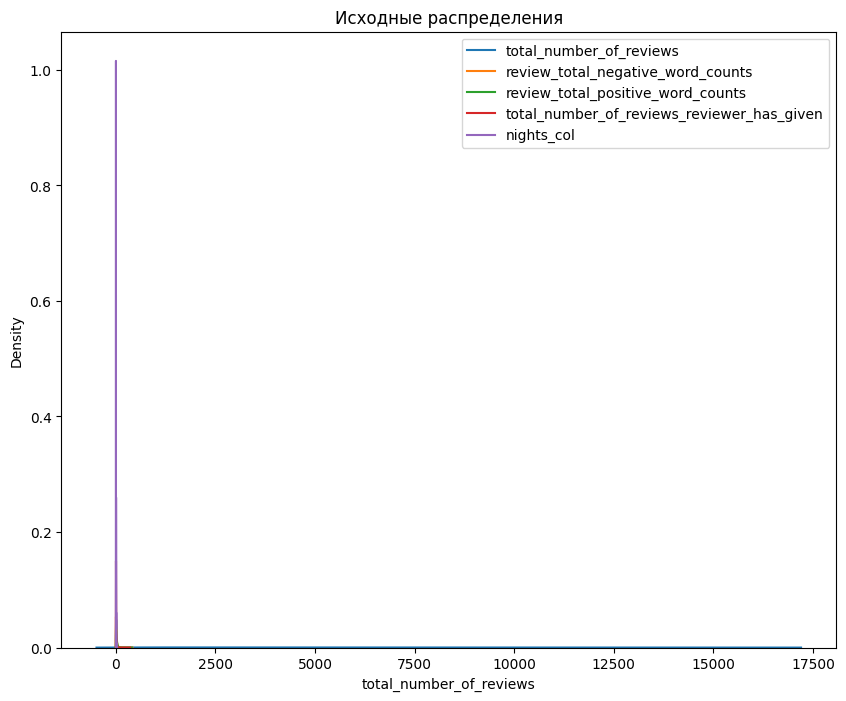

In [275]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(fill_hotels['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(fill_hotels['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(fill_hotels['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(fill_hotels['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(fill_hotels['nights_col'], ax=ax1, label ='nights_col')
plt.legend()

In [276]:
df_num = fill_hotels[['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'nights_col']]
col_names = list(df_num.columns)

<Axes: title={'center': 'После нормализации MinMaxScaler'}, xlabel='total_number_of_reviews', ylabel='Density'>

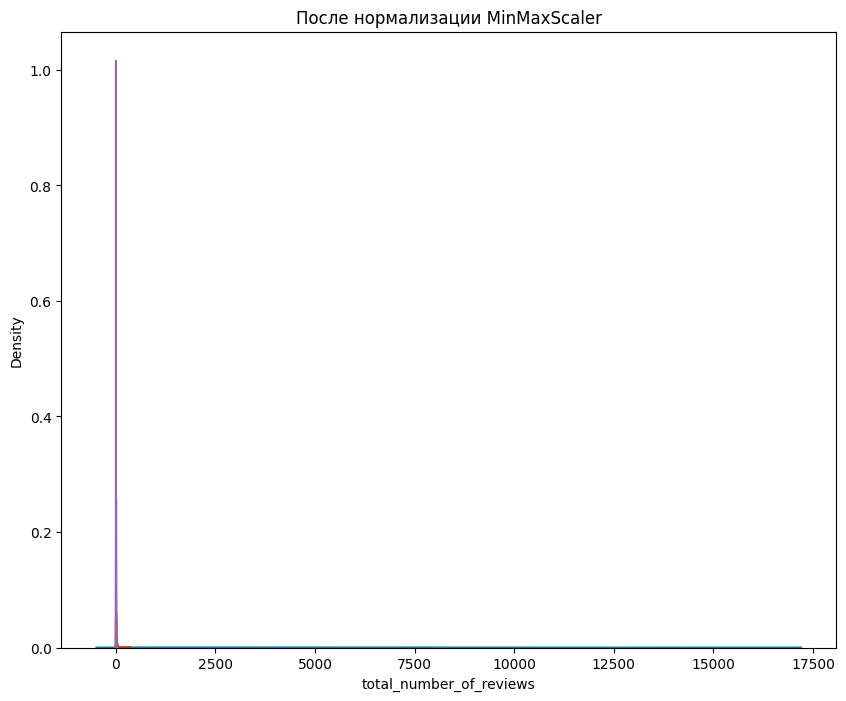

In [277]:
# инициализируем нормализатор MinMaxScaler
mm_scaler =  preprocessing.RobustScaler()

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(df_num)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_num['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(df_num['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(df_num['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(df_num['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(df_num['nights_col'], ax=ax1, label ='nights_col')

In [278]:
fill_hotels.describe()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,country_0,country_1,country_2,reviewer_nationality_0,...,is_negative,is_positive,year,year_0,year_1,Leisure trip,Couple,Solo traveler,mobile submitted,nights_col
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,0.264199,0.343762,0.695336,0.185234,...,0.752052,0.930494,2016.120707,0.487556,0.695868,0.810731,0.489169,0.210016,0.596629,2.361057
std,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,0.440906,0.474963,0.460266,0.388488,...,0.431822,0.254312,0.687740,0.499846,0.460039,0.391723,0.499883,0.407320,0.490575,1.646407
min,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,2016.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,2016.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000
75%,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000
max,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


In [279]:
fill_hotels.drop(columns=['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'nights_col'], axis=1, inplace=True)
fill_hotels = pd.concat([fill_hotels, df_mm])

In [283]:
X = fill_hotels.drop(['reviewer_score'], axis = 1)  
y = fill_hotels['reviewer_score'] 

<Axes: >

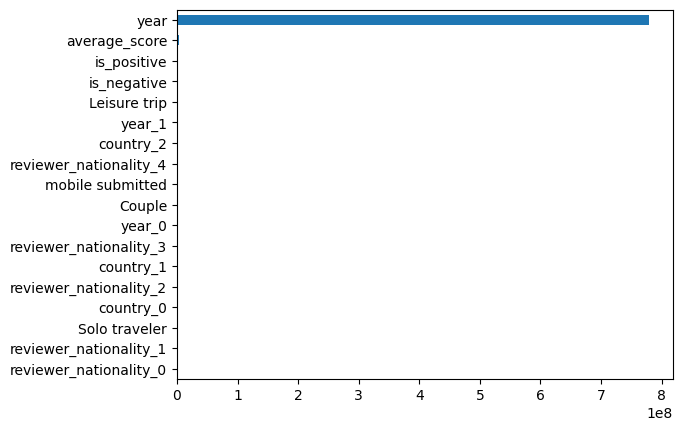

In [284]:
y=y.astype('int')

...
# хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

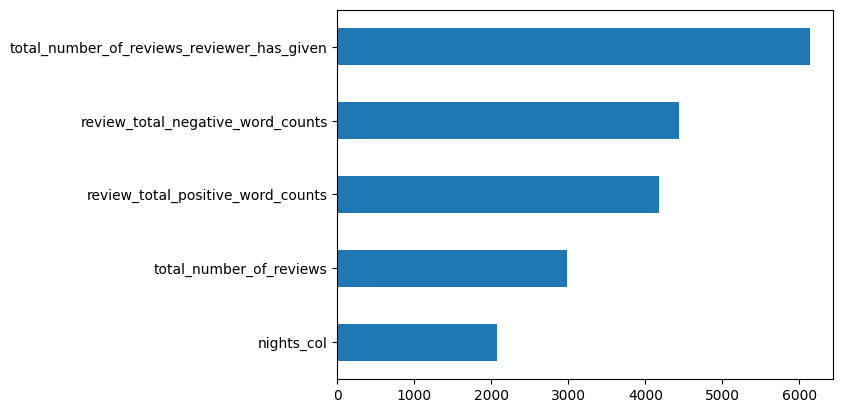

In [287]:
#anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [286]:
fill_hotels.drop(columns=['country_0', 'country_1', 'country_2', 
            'is_negative', 'total_number_of_reviews_reviewer_has_given',
             'total_number_of_reviews'], axis=1, inplace=True)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [289]:
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [290]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.09621470775253632
